# ------------------ PARCELS DELIVERY ANALYSIS ------------------

## A. IMPORT & SETUP

In [3247]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly
import plotly.graph_objects as go
import plotly.express as px

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# mpl.rcParams['figure.facecolor'] = 'white'
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['axes.facecolor'] = 'aliceblue'
plt.rcParams.update({'font.size': 14})

This project contains 2 datasets:

- parcel_table: information about parcels such as pickup_date, final_delivery_date, origin_country, carrier_name, etc..

- log_table: detailed logs of delivery date prediction

### 1. Parcel table

In [3248]:
parcel_tbl = pd.read_csv(r"/Users/thule/Desktop/DSProjects/ParcelPerform/parcel_table.csv", 
                           parse_dates=['picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 'final_delivery_date'])
parcel_tbl["parcel_id"] = parcel_tbl["parcel_id"].astype('str')                          
display(parcel_tbl.head())
parcel_tbl.info()

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,origin_country,destination_country,is_delivered
0,2981186961,Initech,2023-06-20 07:00:11,2023-06-20 20:57:51,2023-06-20 22:18:27,2023-06-20 22:18:27,Australia,Australia,True
1,2948380100,Initech,2023-06-08 06:00:06,2023-06-18 00:12:26,2023-06-18 03:33:55,2023-06-18 03:33:55,Australia,Australia,True
2,2948508927,Initech,2023-06-21 01:45:00,2023-06-21 21:53:58,2023-06-21 23:42:15,2023-06-21 23:42:15,Australia,Australia,True
3,2941258771,Initech,NaT,2023-06-12 00:06:19,2023-06-12 01:18:39,2023-06-12 01:18:39,Australia,Australia,True
4,2980427311,Massive,NaT,2023-06-22 23:09:38,2023-06-23 02:43:15,2023-06-23 02:43:15,Australia,Australia,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50083 entries, 0 to 50082
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              50083 non-null  object        
 1   carrier_name           50063 non-null  object        
 2   picked_up_date         21594 non-null  datetime64[ns]
 3   out_for_delivery_date  49277 non-null  datetime64[ns]
 4   first_attempt_date     49616 non-null  datetime64[ns]
 5   final_delivery_date    49381 non-null  datetime64[ns]
 6   origin_country         50060 non-null  object        
 7   destination_country    50055 non-null  object        
 8   is_delivered           50083 non-null  bool          
dtypes: bool(1), datetime64[ns](4), object(4)
memory usage: 3.1+ MB


In [3249]:
print(f'\nThere are {parcel_tbl["parcel_id"].nunique()} parcels in the parcel_table dataset')


There are 8727 parcels in the parcel_table dataset


This table has 50k rows, 8 columns and 8727. Some columns have lots of missing values

### 2. Log table

In [3250]:
log_tbl = pd.read_csv(r"/Users/thule/Desktop/DSProjects/ParcelPerform/log_table.csv", 
                           parse_dates=['log_timestamp'])
log_tbl["parcel_id"] = log_tbl["parcel_id"].astype('str')  
log_tbl["log_id"] = log_tbl["log_id"].astype('str')                          
display(log_tbl.head())
log_tbl.info()

,log_id,parcel_id,raw_log_description,log_key,log_timestamp,additional_params
0,935869563,2928654176,Carrier EDD generated,EDD101,2023-06-04 00:08:08,"{""event_type_master_data_id"": ""EDD101""}"
1,910688054,2928669922,Carrier EDD generated,EDD101,2023-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
2,910688054,2928669922,Carrier EDD generated,EDD101,2023-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
3,910688054,2928669922,Carrier EDD generated,EDD101,2023-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"
4,910688054,2928669922,Carrier EDD generated,EDD101,2023-06-02 12:20:39,"{""event_type_master_data_id"": ""EDD101""}"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94771 entries, 0 to 94770
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   log_id               94771 non-null  object        
 1   parcel_id            94771 non-null  object        
 2   raw_log_description  94771 non-null  object        
 3   log_key              94771 non-null  object        
 4   log_timestamp        94771 non-null  datetime64[ns]
 5   additional_params    94771 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 4.3+ MB


In [3251]:
print(f'\nThere are {log_tbl["parcel_id"].nunique()} parcels in the parcel_table dataset')


There are 8707 parcels in the parcel_table dataset


This table has around 95k rows, no columns with missing values, and 8707 parcels.

- Column additional_params needs to be json_normalized to extract detailed EDD

## B. QUESTIONS TO ANALYZE

1. Which carrier has the highest EDD accuracy percentage

2. How accurate is EDD?

3. Successful delivery rate

4. Are there any abnormality in the parcels?

5. Characteristics of the accurate EDDs vs inaccurate EDDs.

## C. PRE-PROCESSING

### I. Parcel table

- drop duplicates

- drop cols with lots of missing values

- fillna for some columns

- abnormal values

#### 1. Duplications

In [3252]:
# PERCENTAGE OF DUPLICATIONS
perc = (parcel_tbl.shape[0] - parcel_tbl[~parcel_tbl.duplicated()].shape[0]) / parcel_tbl.shape[0] * 100

# DROP DUPLICATES
parcel_tbl = parcel_tbl.drop_duplicates()
# VERIFY
if parcel_tbl[parcel_tbl.duplicated()].shape[0] == 0:
    print(f'{round(perc,2)} % duplicated values are dropped')

82.52 % duplicated values are dropped


#### 2. Missing values

DROP ROWS WITH MISSING DELIVERY_DATE & CARRIER_NAME

In [3253]:
parcel_tbl = parcel_tbl[~((parcel_tbl['carrier_name'].isna()) &
                           (parcel_tbl['out_for_delivery_date'].isna()) &
                            (parcel_tbl['final_delivery_date'].isna()) )
                            ]
parcel_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8737 entries, 0 to 50069
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              8737 non-null   object        
 1   carrier_name           8737 non-null   object        
 2   picked_up_date         4112 non-null   datetime64[ns]
 3   out_for_delivery_date  8638 non-null   datetime64[ns]
 4   first_attempt_date     8684 non-null   datetime64[ns]
 5   final_delivery_date    8663 non-null   datetime64[ns]
 6   origin_country         8734 non-null   object        
 7   destination_country    8729 non-null   object        
 8   is_delivered           8737 non-null   bool          
dtypes: bool(1), datetime64[ns](4), object(4)
memory usage: 622.9+ KB


FILL MISSING PICKED_UP_DATE & OUT_FOR_DELIVERY_DATE BY ADDING AVG DAYSBW_PICKUP_N_OUT_FOR_DELIVERY

In [3254]:
# CALCULATE AVG DATES BETWEEN PICKED_UP_DATE & OUT_FOR_DELIVERY_DATE OF NORMAL PARCELS
abnormal_parcels = parcel_tbl[parcel_tbl['out_for_delivery_date'] < parcel_tbl['picked_up_date']]
mask = ~parcel_tbl['parcel_id'].isin(abnormal_parcels['parcel_id'])
parcel_tbl['daysbw_pickup_n_out_for_delivery'] = (parcel_tbl[mask]['out_for_delivery_date'] - parcel_tbl[mask]['picked_up_date']) / pd.Timedelta(1, "D")
# parcel_tbl.groupby('parcel_id')['daysbw_pickup_n_out_for_delivery'].mean().describe()

FILLNA_INTERVAL = parcel_tbl.groupby('parcel_id')['daysbw_pickup_n_out_for_delivery'].mean().mean()
parcel_tbl.drop(columns=['daysbw_pickup_n_out_for_delivery'], inplace=True)
# FILLNA FOR PICKED_UP_DATE
parcel_tbl['picked_up_date'].fillna(parcel_tbl['out_for_delivery_date'] - pd.Timedelta(FILLNA_INTERVAL, "D"), inplace=True)
# FILLNA FOR OUT_FOR_DELIVERY_DATE 
parcel_tbl['out_for_delivery_date'].fillna(parcel_tbl['picked_up_date'] + pd.Timedelta(FILLNA_INTERVAL, "D"), inplace=True)
parcel_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8737 entries, 0 to 50069
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              8737 non-null   object        
 1   carrier_name           8737 non-null   object        
 2   picked_up_date         8679 non-null   datetime64[ns]
 3   out_for_delivery_date  8679 non-null   datetime64[ns]
 4   first_attempt_date     8684 non-null   datetime64[ns]
 5   final_delivery_date    8663 non-null   datetime64[ns]
 6   origin_country         8734 non-null   object        
 7   destination_country    8729 non-null   object        
 8   is_delivered           8737 non-null   bool          
dtypes: bool(1), datetime64[ns](4), object(4)
memory usage: 622.9+ KB


FILLNA FOR FIRST_ATTEMPT_DATE

In [3255]:
# CALCULATE AVG DATES BETWEEN FINAL_DELIVERY_DATE & FIRST_ATTEMPT_DATE OF NORMAL PARCELS
abnormal_parcels_2 = parcel_tbl[parcel_tbl['first_attempt_date'] > parcel_tbl['final_delivery_date']]
mask = ~parcel_tbl['parcel_id'].isin(abnormal_parcels_2['parcel_id'])
parcel_tbl['daysbw_first_attempt_n_final_delivery'] = (parcel_tbl[mask]['final_delivery_date'] - parcel_tbl[mask]['first_attempt_date']) / pd.Timedelta(1, "D")
# parcel_tbl.groupby('parcel_id')['daysbw_first_attempt_n_final_delivery'].mean().describe()

FILLNA_INTERVAL_2 = parcel_tbl.groupby('parcel_id')['daysbw_first_attempt_n_final_delivery'].mean().mean()
parcel_tbl.drop(columns=['daysbw_first_attempt_n_final_delivery'], inplace=True)
# FILLNA FOR FIRST_ATTEMPT_DATE
parcel_tbl['first_attempt_date'].fillna(parcel_tbl['final_delivery_date'] - pd.Timedelta(FILLNA_INTERVAL_2, "D"), inplace=True)
parcel_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8737 entries, 0 to 50069
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              8737 non-null   object        
 1   carrier_name           8737 non-null   object        
 2   picked_up_date         8679 non-null   datetime64[ns]
 3   out_for_delivery_date  8679 non-null   datetime64[ns]
 4   first_attempt_date     8686 non-null   datetime64[ns]
 5   final_delivery_date    8663 non-null   datetime64[ns]
 6   origin_country         8734 non-null   object        
 7   destination_country    8729 non-null   object        
 8   is_delivered           8737 non-null   bool          
dtypes: bool(1), datetime64[ns](4), object(4)
memory usage: 622.9+ KB


REMOVE PARCELS WHICH HAVE NOT BEEN DELIVERED (MISSING FINAL_DELIVERY_DATE)

In [3256]:
parcel_tbl = parcel_tbl[(~parcel_tbl['final_delivery_date'].isna() & (~parcel_tbl['out_for_delivery_date'].isna()))].drop(columns=['is_delivered', 'origin_country', 'destination_country'])
parcel_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8626 entries, 0 to 50069
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              8626 non-null   object        
 1   carrier_name           8626 non-null   object        
 2   picked_up_date         8626 non-null   datetime64[ns]
 3   out_for_delivery_date  8626 non-null   datetime64[ns]
 4   first_attempt_date     8626 non-null   datetime64[ns]
 5   final_delivery_date    8626 non-null   datetime64[ns]
dtypes: datetime64[ns](4), object(2)
memory usage: 471.7+ KB


#### 3. Abnormal values

CHECK TIMELINE

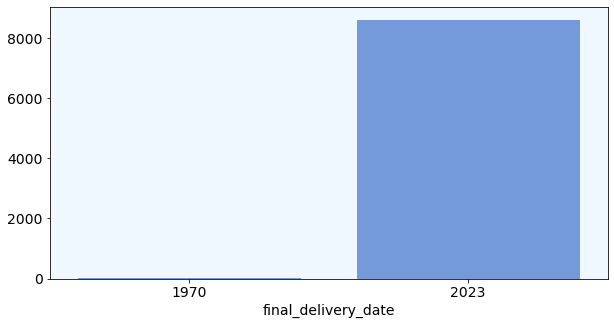

In [3257]:
plot_data = parcel_tbl.copy()
plot_data['final_delivery_date'] = plot_data['final_delivery_date'].dt.year

plt.figure(figsize=(10,5))
sns.barplot(
    x=plot_data.groupby('final_delivery_date')['parcel_id'].count().index,
    y=plot_data.groupby('final_delivery_date')['parcel_id'].count().values, 
    color='cornflowerblue'
)
plt.show()

There are some parcels with delivery_date in 1970 which would be removed

In [3258]:
# REMOVE PARCELS WHICH TIMELINE FROM 1970
parcel_tbl = parcel_tbl[parcel_tbl['final_delivery_date'].dt.year==2023]
parcel_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8596 entries, 0 to 50069
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   parcel_id              8596 non-null   object        
 1   carrier_name           8596 non-null   object        
 2   picked_up_date         8596 non-null   datetime64[ns]
 3   out_for_delivery_date  8596 non-null   datetime64[ns]
 4   first_attempt_date     8596 non-null   datetime64[ns]
 5   final_delivery_date    8596 non-null   datetime64[ns]
dtypes: datetime64[ns](4), object(2)
memory usage: 470.1+ KB


### II. Log table

- drop duplicates

- extract columns from json

- remove duplicated consecutive EDD

#### 1. DUPLICATIONS

In [3259]:
# PERCENTAGE OF DUPLICATIONS
perc = (log_tbl.shape[0] - log_tbl[~log_tbl.duplicated()].shape[0]) / log_tbl.shape[0] * 100

# DROP DUPLICATES
log_tbl = log_tbl.drop_duplicates()
# VERIFY
if log_tbl[log_tbl.duplicated()].shape[0] == 0:
    print(f'{round(perc,2)} % duplicated values are dropped')

43.65 % duplicated values are dropped


#### 2. EXTRACT COLUMNS FROM JSON

In [3260]:
import json
tmp = log_tbl['additional_params'].apply(json.loads)
additional_params_df = pd.DataFrame(tmp.tolist())
log_tbl.reset_index(drop=True, inplace=True)
# CONCAT NEW COLUMNS TO ORIGINAL TABLE
logs = pd.concat([log_tbl.iloc[:,:-1], additional_params_df], axis=1)
logs = logs[logs['log_key']=='EDD102']
logs = logs[['parcel_id', 'log_timestamp', 'new_parcel_expected_time_first_start', 'new_parcel_expected_time_first_end', 'old_parcel_expected_time_first_start', 'old_parcel_expected_time_first_end', 'new_parcel_expected_time_latest_start', 'old_parcel_expected_time_latest_start']]

logs['new_parcel_expected_time_first_start'] = logs['new_parcel_expected_time_first_start'].replace('T', ' ').str.rsplit('+').str[0]
logs['new_parcel_expected_time_first_end'] = logs['new_parcel_expected_time_first_end'].str.rsplit('+').str[0]
logs['new_parcel_expected_time_latest_start'] = logs['new_parcel_expected_time_latest_start'].str.rsplit('+').str[0]

# CHANGE DTYPE
logs['new_parcel_expected_time_first_start'] = pd.to_datetime(logs['new_parcel_expected_time_first_start'], format="%Y-%m-%d %H:%M:%S") 
logs['new_parcel_expected_time_first_end'] = pd.to_datetime(logs['new_parcel_expected_time_first_end'])
logs['old_parcel_expected_time_first_start'] = pd.to_datetime(logs['old_parcel_expected_time_first_start']).dt.tz_localize(None)
logs['old_parcel_expected_time_first_end'] = pd.to_datetime(logs['old_parcel_expected_time_first_end']).dt.tz_localize(None)
logs['new_parcel_expected_time_latest_start'] = pd.to_datetime(logs['new_parcel_expected_time_latest_start'])
logs['old_parcel_expected_time_latest_start'] = pd.to_datetime(logs['old_parcel_expected_time_latest_start']).dt.tz_localize(None)

# FILL MISSING VALUES BECAUSE THESE COLUMNS HAVE SAME MEANING
logs['new_parcel_expected_time_first_start'] = logs['new_parcel_expected_time_first_start'].fillna(logs['new_parcel_expected_time_latest_start'])
logs['old_parcel_expected_time_first_start'] = logs['old_parcel_expected_time_first_start'].fillna(logs['old_parcel_expected_time_latest_start'])

# DROP OLD_EDD & LATEST_START
logs.drop(columns=['old_parcel_expected_time_first_start', 'old_parcel_expected_time_first_end', 'new_parcel_expected_time_latest_start', 'old_parcel_expected_time_latest_start'], inplace=True)

display(logs.head())
logs.info()

,parcel_id,log_timestamp,new_parcel_expected_time_first_start,new_parcel_expected_time_first_end
2,2928669922,2023-06-02 13:15:55,2023-06-05,2023-06-08 23:59:59
3,2928669922,2023-06-02 14:11:14,2023-06-05,2023-06-08 23:59:59
4,2928669922,2023-06-02 15:08:06,2023-06-05,2023-06-08 23:59:59
5,2928669922,2023-06-02 16:03:52,2023-06-05,2023-06-08 23:59:59
6,2928669922,2023-06-02 17:52:25,2023-06-05,2023-06-08 23:59:59


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44692 entries, 2 to 53394
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   parcel_id                             44692 non-null  object        
 1   log_timestamp                         44692 non-null  datetime64[ns]
 2   new_parcel_expected_time_first_start  44622 non-null  datetime64[ns]
 3   new_parcel_expected_time_first_end    25538 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(1)
memory usage: 1.7+ MB


#### 3. REMOVE DUPLICATED CONSECUTIVE EDD PER PARCEL

In [3261]:
# SHIFT EDD DOWN 1 ROW AND CONCAT TO ORIGINAL LOG
tmp_log = pd.concat([logs.iloc[:,:3], logs.groupby('parcel_id')['new_parcel_expected_time_first_start'].shift(-1)], axis=1)
tmp_log.columns = ['parcel_id', 'log_timestamp', 'new_parcel_expected_time_first_start', 'next_EDD']
# IF DUPLICATED CONSECUTIVE EDD THEN REMOVE
tmp_log = tmp_log[tmp_log['new_parcel_expected_time_first_start']!=tmp_log['next_EDD']]

# MERGE
log_tbl2 = tmp_log.drop(columns=['next_EDD']).merge(logs['new_parcel_expected_time_first_end'], left_index=True, right_index=True)
log_tbl2

,parcel_id,log_timestamp,new_parcel_expected_time_first_start,new_parcel_expected_time_first_end
45,2928669922,2023-06-04 23:32:09,2023-06-05 00:00:00,2023-06-08 23:59:59
58,2928713073,2023-06-06 03:33:07,2023-06-07 23:59:59,2023-06-09 23:59:59
73,2928713073,2023-06-08 03:05:26,2023-06-09 00:00:00,2023-06-14 23:59:59
75,2928714933,2023-06-05 08:14:37,2023-06-06 23:59:59,2023-06-08 23:59:59
88,2928718349,2023-06-05 12:51:35,2023-06-06 23:59:59,2023-06-08 23:59:59
...,...,...,...,...
53342,3008226906,2023-06-29 20:48:07,2023-07-03 23:59:59,NaT
53352,3008283416,2023-06-29 21:04:53,2023-07-03 00:00:00,NaT
53359,3008314095,2023-06-30 06:16:04,2023-07-03 00:00:00,2023-07-05 23:59:59
53362,3008359149,2023-06-29 18:54:06,2023-07-03 00:00:00,NaT


### III. Final table

- merge parcel_table & log_table

- add columns: EDD_is_accurate, is_abnormal, daydiff_bw_FDD_EDD, daydiff_log_FDD,...

- remove abnormal EDDs/parcels

#### 1. Merge 2 tables

This dataset contains EDDs after removing duplicated consecutive EDD logs of both normal & abnormal parcels

In [3262]:
merge_tbl = parcel_tbl.merge(log_tbl2, how='inner', on='parcel_id')
merge_tbl.head()

,parcel_id,carrier_name,picked_up_date,out_for_delivery_date,first_attempt_date,final_delivery_date,log_timestamp,new_parcel_expected_time_first_start,new_parcel_expected_time_first_end
0,2948380100,Initech,2023-06-08 06:00:06.000000000,2023-06-18 00:12:26,2023-06-18 03:33:55,2023-06-18 03:33:55,2023-06-17 23:02:33,2023-06-19 00:00:00.000,2023-06-22 23:59:59
1,2948508927,Initech,2023-06-21 01:45:00.000000000,2023-06-21 21:53:58,2023-06-21 23:42:15,2023-06-21 23:42:15,2023-06-21 19:52:25,2023-06-22 00:00:00.000,NaT
2,2941258771,Initech,2023-06-08 17:56:42.026329600,2023-06-12 00:06:19,2023-06-12 01:18:39,2023-06-12 01:18:39,2023-06-11 23:59:30,2023-06-12 00:00:00.000,2023-06-15 23:59:59
3,2980427311,Massive,2023-06-19 17:00:01.026329600,2023-06-22 23:09:38,2023-06-23 02:43:15,2023-06-23 02:43:15,2023-06-20 02:24:09,2023-06-23 21:59:59.999,NaT
4,2980427311,Massive,2023-06-19 17:00:01.026329600,2023-06-22 23:09:38,2023-06-23 02:43:15,2023-06-23 02:43:15,2023-06-20 04:05:41,2023-06-23 23:59:59.999,NaT


#### 2. CHECK IF EDD IS ACCURATE

EDD IS CONSIDERED ACCURATE IF:

- FINAL DELIVERY DATE (FDD) IS IN RANGE (NEW_PARCEL_EXPECTED_TIME_FIRST_START - NEW_PARCEL_EXPECTED_TIME_FIRST_END)
OR

- FDD IS ON THE SAME DATE AS EDD (ONLY IF EITHER NEW_PARCEL_EXPECTED_TIME_FIRST_START OR NEW_PARCEL_EXPECTED_TIME_FIRST_END IS MISSING)

In [3263]:
# ADD EDD_IS_ACCURATE COLUMN
merge_tbl.loc[((merge_tbl['final_delivery_date'] > merge_tbl['new_parcel_expected_time_first_start']) & (merge_tbl['final_delivery_date'] < merge_tbl['new_parcel_expected_time_first_end'])) # FDD is in expected range
              | ((merge_tbl['new_parcel_expected_time_first_start'].isna()) & (merge_tbl['final_delivery_date'].dt.date == merge_tbl['new_parcel_expected_time_first_end'].dt.date)) # FDD on the same date if range not given
              | ((merge_tbl['new_parcel_expected_time_first_end'].isna()) & (merge_tbl['final_delivery_date'].dt.date == merge_tbl['new_parcel_expected_time_first_start'].dt.date))
              , 'EDD_is_accurate'] = True
merge_tbl['EDD_is_accurate'].fillna(False, inplace=True)
merge_tbl['picked_up_date'] = merge_tbl['picked_up_date'].astype('datetime64[s]')

merge_tbl = merge_tbl[['parcel_id', 'carrier_name', 'EDD_is_accurate', 'log_timestamp', 'final_delivery_date',
                                 'new_parcel_expected_time_first_start', 'new_parcel_expected_time_first_end',
                                 'picked_up_date', 'out_for_delivery_date', 'first_attempt_date',
       ]]
merge_tbl.head()

,parcel_id,carrier_name,EDD_is_accurate,log_timestamp,final_delivery_date,new_parcel_expected_time_first_start,new_parcel_expected_time_first_end,picked_up_date,out_for_delivery_date,first_attempt_date
0,2948380100,Initech,False,2023-06-17 23:02:33,2023-06-18 03:33:55,2023-06-19 00:00:00.000,2023-06-22 23:59:59,2023-06-08 06:00:06,2023-06-18 00:12:26,2023-06-18 03:33:55
1,2948508927,Initech,False,2023-06-21 19:52:25,2023-06-21 23:42:15,2023-06-22 00:00:00.000,NaT,2023-06-21 01:45:00,2023-06-21 21:53:58,2023-06-21 23:42:15
2,2941258771,Initech,True,2023-06-11 23:59:30,2023-06-12 01:18:39,2023-06-12 00:00:00.000,2023-06-15 23:59:59,2023-06-08 17:56:42,2023-06-12 00:06:19,2023-06-12 01:18:39
3,2980427311,Massive,True,2023-06-20 02:24:09,2023-06-23 02:43:15,2023-06-23 21:59:59.999,NaT,2023-06-19 17:00:01,2023-06-22 23:09:38,2023-06-23 02:43:15
4,2980427311,Massive,True,2023-06-20 04:05:41,2023-06-23 02:43:15,2023-06-23 23:59:59.999,NaT,2023-06-19 17:00:01,2023-06-22 23:09:38,2023-06-23 02:43:15


In [3264]:
# ADD MEDIAN EXPECTED_DELIVERY_TIME OF FIRST_START & FIRST_END RANGE
merge_tbl['new_parcel_expected_median_time'] = merge_tbl['new_parcel_expected_time_first_start'] + (merge_tbl['new_parcel_expected_time_first_end'] - merge_tbl['new_parcel_expected_time_first_start'])/2 
# ADD EDD COLUMN
merge_tbl['EDD'] = merge_tbl['new_parcel_expected_median_time']
merge_tbl.loc[(merge_tbl['new_parcel_expected_time_first_end'].isna()), 'EDD'] = merge_tbl['new_parcel_expected_time_first_start']
merge_tbl.loc[(merge_tbl['new_parcel_expected_time_first_start'].isna()), 'EDD'] = merge_tbl['new_parcel_expected_time_first_end']

# DAYS BETWEEN FINAL_DELIVERY_DATE & EXPECTED DELIVERY DATE
merge_tbl['daydiff_bw_FDD_EDD'] = (merge_tbl['final_delivery_date']- merge_tbl['EDD']) / pd.Timedelta(1,"D")
# DAYS  BETWEEN FINAL_DELIVERY_DATE & PREDICTION LOG DATE
merge_tbl['daydiff_log_FDD'] = (merge_tbl['log_timestamp'] - merge_tbl['final_delivery_date']) / pd.Timedelta(1,"D")

# DROP UNNESCESSARY COLUMN
merge_tbl.drop(columns=['new_parcel_expected_median_time'], inplace=True)
# merge_tbl.drop(columns=['new_parcel_expected_median_time', 'picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 'origin_country', 'destination_country'], inplace=True)

#### 2. ADD FLAG IS_ABNORMAL TO FINAL_TABLE

An EDD is considered abnormal if either:

1. picked_up_date > out_for_delivery_date

2. out_for_delivery_date > first_attempt_date

3.  out_for_delivery_date >= final_delivery_date

4. first_attempt_date > final_delivery_date

5. log_timestamp > final_delivery_date

In [3265]:
merge_tbl.loc[(merge_tbl['picked_up_date'] > merge_tbl['out_for_delivery_date'])
          | (merge_tbl['out_for_delivery_date'] > merge_tbl['first_attempt_date'])
          | (merge_tbl['out_for_delivery_date'] >= merge_tbl['final_delivery_date'])
          | (merge_tbl['first_attempt_date'] > merge_tbl['final_delivery_date'])
          | (merge_tbl['log_timestamp'] > merge_tbl['final_delivery_date'])
          , 'is_abnormal'
        ] = True
merge_tbl['is_abnormal'].fillna(False, inplace=True)

# ADD ABNORMAL_REASON COLUMN
merge_tbl.loc[merge_tbl['picked_up_date'] > merge_tbl['out_for_delivery_date'], 'abnormal_reason'] = '1'
merge_tbl.loc[merge_tbl['out_for_delivery_date'] > merge_tbl['first_attempt_date'], 'abnormal_reason'] = '2'
merge_tbl.loc[merge_tbl['out_for_delivery_date'] >= merge_tbl['final_delivery_date'], 'abnormal_reason'] = '3'
merge_tbl.loc[merge_tbl['first_attempt_date'] > merge_tbl['final_delivery_date'], 'abnormal_reason'] = '4'
merge_tbl.loc[merge_tbl['log_timestamp'] > merge_tbl['final_delivery_date'], 'abnormal_reason'] = '5'

merge_tbl['abnormal_reason'].fillna(0, inplace=True)

In [3266]:
COUNT_ABNORMAL_EDDS = merge_tbl[merge_tbl['is_abnormal']==True].parcel_id.count()
TOTAL_PARCELS = merge_tbl.parcel_id.nunique()
TOTAL_EDDS = merge_tbl.parcel_id.count()
PERC = COUNT_ABNORMAL_EDDS / TOTAL_EDDS * 100

print(f'THERE ARE {COUNT_ABNORMAL_EDDS} ABNORMAL EDDS')
print(f'ACCOUNTING FOR {round(PERC,2)} % OF TOTAL EDDS IN THE FINAL DATASET.')

THERE ARE 503 ABNORMAL EDDS
ACCOUNTING FOR 7.61 % OF TOTAL EDDS IN THE FINAL DATASET.


##### 2.1 Reasons of abnormal EDDs plot

In [3267]:
# MAPPING Y-AXIS LABEL
dict = {'1': 'pickup_date after out_for_delivery_date',
        '2': 'out_for_delivery_date after first_attempt_date',
        '3': 'out_for_delivery_date after final_delivery_date',
        '4': 'first_attempt_date after final_delivery_date',
        '5': 'EDD_log_date after final_delivery_date'
        }
plot_data = merge_tbl[merge_tbl['is_abnormal']==True].groupby('abnormal_reason')['parcel_id'].count().reset_index(name='abnormal_EDDs')\
            .sort_values('abnormal_EDDs', ascending=True)
plot_data['perc_parcels_%'] = plot_data['abnormal_EDDs'] / merge_tbl['parcel_id'].nunique() * 100
plot_data['abnormal_reason'] = plot_data['abnormal_reason'].map(dict)
# PLOT
# plt.figure(figsize=(10,5))
# ax = sns.countplot(data=plot_data, y='abnormal_reason', orient='h',
#               color='cornflowerblue'
#               )
# ax.bar_label(ax.containers[0], labels = [f'{w} ({(w/TOTAL_PARCELS)*100:0.2f}%)' if (w := v.get_width()) > 0 else '' for v in ax.containers[0]])

# ax.set_title("ABNORMAL REASONS", size=16)
# ax.set_xlabel("number of parcels")
# ax.set_ylabel("")
# plt.show()

fig=go.Figure()
fig.add_trace(go.Bar(
                    y=plot_data['abnormal_reason'], 
                    x=plot_data['abnormal_EDDs'], orientation='h',
                    name='abnormal_reason', marker_color='darkblue',
                    customdata=plot_data['perc_parcels_%'],
                    texttemplate = '%{x:,.0f} parcels<br>(%{customdata:.2f} %)',
                    textposition='outside'
                    ))
# fig.add_trace(go.Scatter(
#                     x=plot_data['carrier_name'], 
#                     y=plot_data['EDD_count'], name='EDDs count',
#                     mode='markers+lines+text',
#                     texttemplate = '%{y:,.0f}',
#                     textposition='top right', textfont_color='red'
# ))

fig.update_layout(
    width=1000,
    height=500,
    title='<b>ABNORMAL REASONS</b>', title_font={'size':20},
    title_x=.5, title_y=.9,
    xaxis={'range': [0,300]}, 
    # yaxis2={'range': [0,4500]}, 
)
fig.show()

##### 2.2 Abnormal EDDs per carrier plot

In [3268]:
def func(df):
    cols = {
    'total_EDDs': df['parcel_id'].count(),
    'is_abnormal' : df[df['is_abnormal']==True]['parcel_id'].count(),
    'not_abnormal' : df[df['is_abnormal']==False]['parcel_id'].count(),
    'perc_is_abnormal' : df[df['is_abnormal']==True]['parcel_id'].count() / df['parcel_id'].count() * 100,
    'perc_not_abnormal' : df[df['is_abnormal']==False]['parcel_id'].count() / df['parcel_id'].count() * 100,
    }
    return pd.Series(cols)
plot_data = merge_tbl.groupby('carrier_name').apply(func).reset_index().sort_values('perc_is_abnormal', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(x=plot_data['carrier_name'], y=plot_data['perc_is_abnormal'],
                    texttemplate=[f'{x:.2f} %<br>({y:,.0f} EDDs)' for x,y in zip(plot_data['perc_is_abnormal'], plot_data['is_abnormal'])],
                      marker_color='darkblue', name='is_abnormal'))
# fig.add_trace(go.Bar(y=plot_data['carrier_name'], x=plot_data['perc_not_abnormal'], 
#                     texttemplate=[f'{x:.2f}%<br>({y:,.0f} EDDs)' for x,y in zip(plot_data['perc_not_abnormal'], plot_data['not_abnormal'])],
#                      marker_color='cornflowerblue', name='not_abnormal', orientation='h'))

# fig.update_layout(barmode='stack')
fig.update_traces(textposition='outside', textfont_color='black')
fig.update_layout(
    width=800,
    height=500,
    title='<b>ABNORMAL EDDs PER CARRIER</b>', title_font={'size':20},
    title_x=.5, title_y=.9,
    xaxis={'showgrid':False}, 
    yaxis={'title':'Percentage %', 'range':[0,100], 'dtick':25}
)
display(plot_data)
fig.show()

,carrier_name,total_EDDs,is_abnormal,not_abnormal,perc_is_abnormal,perc_not_abnormal
0,Globex,57.00,6.00,51.00,10.53,89.47
2,Massive,"2,261.00",190.00,"2,071.00",8.40,91.60
1,Initech,"4,295.00",307.00,"3,988.00",7.15,92.85


THE ABNORMAL EDDS WILL BE REMOVED FROM THE ANALYSIS BELOW

#### 2. REMOVE ABNORMAL EDDS

This dataset contains only normal EDDs of parcels after removing consecutive duplicated EDDs per parcel.

In [3269]:
normal_edd_tbl = merge_tbl[merge_tbl['is_abnormal']==False]
normal_edd_tbl = normal_edd_tbl[['parcel_id', 'carrier_name', 'EDD_is_accurate', 'log_timestamp', 'final_delivery_date',
                                 'new_parcel_expected_time_first_start', 'new_parcel_expected_time_first_end', 'EDD',
                                 'picked_up_date', 'out_for_delivery_date', 'first_attempt_date', 
                                'daydiff_bw_FDD_EDD', 'daydiff_log_FDD'
                                 ]]
normal_edd_tbl.head()

,parcel_id,carrier_name,EDD_is_accurate,log_timestamp,final_delivery_date,new_parcel_expected_time_first_start,new_parcel_expected_time_first_end,EDD,picked_up_date,out_for_delivery_date,first_attempt_date,daydiff_bw_FDD_EDD,daydiff_log_FDD
0,2948380100,Initech,False,2023-06-17 23:02:33,2023-06-18 03:33:55,2023-06-19 00:00:00.000,2023-06-22 23:59:59,2023-06-20 23:59:59.500,2023-06-08 06:00:06,2023-06-18 00:12:26,2023-06-18 03:33:55,-2.85,-0.19
1,2948508927,Initech,False,2023-06-21 19:52:25,2023-06-21 23:42:15,2023-06-22 00:00:00.000,NaT,2023-06-22 00:00:00.000,2023-06-21 01:45:00,2023-06-21 21:53:58,2023-06-21 23:42:15,-0.01,-0.16
2,2941258771,Initech,True,2023-06-11 23:59:30,2023-06-12 01:18:39,2023-06-12 00:00:00.000,2023-06-15 23:59:59,2023-06-13 23:59:59.500,2023-06-08 17:56:42,2023-06-12 00:06:19,2023-06-12 01:18:39,-1.95,-0.05
3,2980427311,Massive,True,2023-06-20 02:24:09,2023-06-23 02:43:15,2023-06-23 21:59:59.999,NaT,2023-06-23 21:59:59.999,2023-06-19 17:00:01,2023-06-22 23:09:38,2023-06-23 02:43:15,-0.80,-3.01
4,2980427311,Massive,True,2023-06-20 04:05:41,2023-06-23 02:43:15,2023-06-23 23:59:59.999,NaT,2023-06-23 23:59:59.999,2023-06-19 17:00:01,2023-06-22 23:09:38,2023-06-23 02:43:15,-0.89,-2.94


## D. ANALYSIS

### **I. OVERVIEW**

- Dataset info

- Number of parcels

- Timeline of dataset

- Carrier volume

- EDD Frequency

#### 1. DATASET

In [3270]:
normal_edd_tbl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6110 entries, 0 to 6612
Data columns (total 13 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   parcel_id                             6110 non-null   object        
 1   carrier_name                          6110 non-null   object        
 2   EDD_is_accurate                       6110 non-null   bool          
 3   log_timestamp                         6110 non-null   datetime64[ns]
 4   final_delivery_date                   6110 non-null   datetime64[ns]
 5   new_parcel_expected_time_first_start  6040 non-null   datetime64[ns]
 6   new_parcel_expected_time_first_end    2201 non-null   datetime64[ns]
 7   EDD                                   6110 non-null   datetime64[ns]
 8   picked_up_date                        6110 non-null   datetime64[ns]
 9   out_for_delivery_date                 6110 non-null   datetime64[ns]
 10  

In [3271]:
print(f'The final dataset contains only normal EDDs and has {normal_edd_tbl.shape[0]} rows (EDDs) and {normal_edd_tbl.shape[1]} columns')

The final dataset contains only normal EDDs and has 6110 rows (EDDs) and 13 columns


#### 2. NUMBER OF PARCELS

In [3272]:
TOTAL_PARCELS = normal_edd_tbl["parcel_id"].nunique()
print(f'There are {TOTAL_PARCELS} parcels in the final dataset')

There are 3205 parcels in the final dataset


There are about more than 8k parcels in the original tables. 

This number dropped down to 3291 parcels in the final table because:

- Many parcels don't have EDD predictions updated (log_key = 'EDD102') in the log_table and were removed.

- Some parcels don't have information in parcel_table nor log_table and were removed.

- Some parcels don't have final_delivery_date & out_for_delivery_date & carrier_name and were removed.

- Some parcels have delivery date in 1970 which are invalid and were removed.

- Some parcels only have abnormal EDDs and were removed.


#### 3. TIMELINE

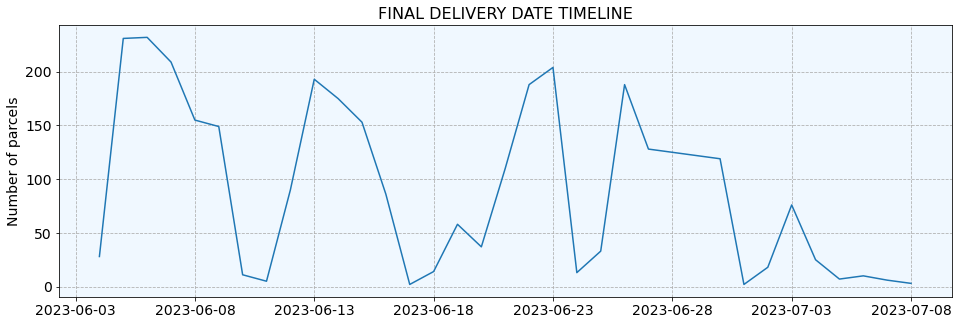

In [3273]:
import matplotlib.dates as mdates
plot_data = normal_edd_tbl.copy()
plot_data['final_delivery_date'] = plot_data['final_delivery_date'].dt.date

plt.figure(figsize=(16,5))
ax = sns.lineplot(
    x=plot_data.groupby('final_delivery_date')['parcel_id'].nunique().index,
    y=plot_data.groupby('final_delivery_date')['parcel_id'].nunique().values,   
)
XTICK_INTERVAL = 5
ax.xaxis.set_major_locator(mdates.DayLocator(interval=XTICK_INTERVAL))
plt.title('FINAL DELIVERY DATE TIMELINE', size=16)
plt.xlabel('')
plt.ylabel('Number of parcels')
plt.grid(axis='both', which='both', linestyle='--')
plt.show()

The final dataset contains parcels delivered from 04-June-2023 to 08-July-2023.

#### 4. CARRIERS

In [3274]:
# PREPARE DATA
from plotly.subplots import make_subplots
summary_tbl = normal_edd_tbl.groupby('carrier_name').agg(
    # EDD_count = ('parcel_id', 'count'),
    parcels_count = ('parcel_id', 'nunique')
).reset_index().sort_values('parcels_count', ascending=True)

summary_tbl.iloc[:,1:3] = summary_tbl.iloc[:,1:3].astype(int)
summary_tbl.set_index('carrier_name', inplace=True)
summary_tbl.loc['All carriers',:] = summary_tbl.iloc[:,:].sum(axis=0, numeric_only=True)
summary_tbl['perc_parcels_%'] = summary_tbl['parcels_count'] / TOTAL_PARCELS * 100
summary_tbl.reset_index(inplace=True)
summary_tbl.iloc[:,1] = summary_tbl.iloc[:,1].astype(int)
display(summary_tbl)

plot_data = summary_tbl.iloc[:-1].copy()
# fig = make_subplots(specs=[[{"secondary_y": True}]])
fig=go.Figure()
fig.add_trace(go.Bar(
                    y=plot_data['carrier_name'], 
                    x=plot_data['parcels_count'], orientation='h',
                    name='Parcels count', marker_color='darkblue',
                    customdata=plot_data['perc_parcels_%'],
                    texttemplate = '%{x:,.0f} parcels<br>(%{customdata:.2f} %)',
                    textposition='outside'
                    ))
# fig.add_trace(go.Scatter(
#                     x=plot_data['carrier_name'], 
#                     y=plot_data['EDD_count'], name='EDDs count',
#                     mode='markers+lines+text',
#                     texttemplate = '%{y:,.0f}',
#                     textposition='top right', textfont_color='red'
# ))

fig.update_layout(
    width=1000,
    height=500,
    title='<b>NUMBER OF PARCELS PER CARRIER</b>', title_font={'size':20},
    title_x=.5, title_y=.9,
    xaxis={'range': [0,4000]}, 
    # yaxis2={'range': [0,4500]}, 
)
fig.show()

,carrier_name,parcels_count,perc_parcels_%
0,Globex,45,1.40
1,Massive,91,2.84
2,Initech,3069,95.76
3,All carriers,3205,100.00


In [3275]:
summary_tbl.set_index('carrier_name', inplace=True)

print(f'''
Initech has the highest amount of deliveries ({summary_tbl.loc["Initech", "parcels_count"]:,.0f} parcels) which takes up {summary_tbl.loc["Initech", "perc_parcels_%"]:.2f} % of total deliveries.

Where as Globex has the lowest volume ({summary_tbl.loc["Globex", "parcels_count"]:,.0f} parcels) and take up {summary_tbl.loc["Globex", "perc_parcels_%"]:.2f} % of total volume.

Massive's volume is also very low compared to Initech's, it has {summary_tbl.loc["Massive", "parcels_count"]:,.0f} parcels which account for {summary_tbl.loc["Massive", "perc_parcels_%"]:.2f} % total volume.''')


Initech has the highest amount of deliveries (3,069 parcels) which takes up 95.76 % of total deliveries.

Where as Globex has the lowest volume (45 parcels) and take up 1.40 % of total volume.

Massive's volume is also very low compared to Initech's, it has 91 parcels which account for 2.84 % total volume.


#### 5. EDD FREQUENCY 

In [3276]:
# PREPARE DATA
# ADD INTERVAL BW LOGS COLUMN
tmp = pd.concat([normal_edd_tbl[['parcel_id']], normal_edd_tbl.groupby('parcel_id')['log_timestamp'].shift(1)], axis=1) # SHIFT LOG_TIMESTAMP DOWN 1 ROW AND CONCAT TO ORIGINAL LOG
tmp.columns = ['parcel_id', 'previous_log_timestamp']
normal_edd_concat_tbl = normal_edd_tbl.merge(tmp[['previous_log_timestamp']], how='inner', left_index=True, right_index=True)
normal_edd_concat_tbl['interval_bw_logs'] = (normal_edd_concat_tbl['log_timestamp'] - normal_edd_concat_tbl['previous_log_timestamp']) / pd.Timedelta(1, "D")

# CALCULATE FREQ & INTERVAL PER PARCEL
normal_edd_freq_interval = normal_edd_concat_tbl.groupby('parcel_id').agg(
    EDD_freq_per_parcel = ('log_timestamp', 'count'),
    avg_days_bw_EDD_per_parcel = ('interval_bw_logs', 'mean'),
    # delivery_duration_days = ('delivery_duration_days', 'first')
).reset_index()

# PARCELS HAVING 1 EDD
ONE_EDD_PARCELS = normal_edd_freq_interval[normal_edd_freq_interval['EDD_freq_per_parcel']==1].parcel_id.unique()
COUNT_ONE_EDD = len(ONE_EDD_PARCELS)
PERC_ONE_EDD_FREQ = COUNT_ONE_EDD / TOTAL_PARCELS * 100
print(f'PERCENTAGE OF PARCELS HAVING ONLY 1 UNIQUE EDD = {PERC_ONE_EDD_FREQ:.2f} % ({COUNT_ONE_EDD:,} parcels)')

# PARCELS HAVING > 1 EDD
MULTI_EDD_PARCELS = normal_edd_freq_interval[normal_edd_freq_interval['EDD_freq_per_parcel'] > 1].parcel_id.unique()
COUNT_MULTI_EDD = len(MULTI_EDD_PARCELS)
PERC_MULTI_EDD_FREQ = COUNT_MULTI_EDD / TOTAL_PARCELS * 100
print(f'PERCENTAGE OF PARCELS HAVING\t> 1 UNIQUE EDD = {PERC_MULTI_EDD_FREQ:.2f} % ({COUNT_MULTI_EDD:,} parcels)')

PERCENTAGE OF PARCELS HAVING ONLY 1 UNIQUE EDD = 80.37 % (2,576 parcels)
PERCENTAGE OF PARCELS HAVING	> 1 UNIQUE EDD = 19.63 % (629 parcels)


### **II. SUCCESSFUL DELIVERY PERCENTAGE ON FIRST ATTEMPT**

##### 1. MULTI DELIVERY PERCENTAGE

In [3348]:
COUNT_MULTI_DELIVERY = normal_edd_tbl[normal_edd_tbl['first_attempt_date'] != normal_edd_tbl['final_delivery_date']].parcel_id.nunique()
PERC_MULTI_DELIVERY = COUNT_MULTI_DELIVERY / TOTAL_PARCELS * 100
print(f'{round(PERC_MULTI_DELIVERY,2)}% ({COUNT_MULTI_DELIVERY:,} parcels) PARCELS WERE DELIVERED AFTER MULTIPLE TIMES')

13.95% (447 parcels) PARCELS WERE DELIVERED AFTER MULTIPLE TIMES


##### 2. ONE-TIME DELIVERY PERCENTAGE

In [3347]:
COUNT_ONETIME_DELIVERY = normal_edd_tbl[normal_edd_tbl['first_attempt_date'] == normal_edd_tbl['final_delivery_date']].parcel_id.nunique()
PERC_ONETIME_DELIVERY = COUNT_ONETIME_DELIVERY / TOTAL_PARCELS * 100
print(f'{round(PERC_ONETIME_DELIVERY,2)}% ({COUNT_ONETIME_DELIVERY:,} parcels) PARCELS WERE DELIVERED AFTER ONE TIME')

86.05% (2,758 parcels) PARCELS WERE DELIVERED AFTER ONE TIME


##### 3. PERCENTAGE PLOT

In [3279]:
def func(df):
    cols = {
    'is_onetime' : df[df['first_attempt_date'] == df['final_delivery_date']]['parcel_id'].nunique(),
    'is_multitime' : df[df['first_attempt_date'] != df['final_delivery_date']]['parcel_id'].nunique(),
    'perc_is_onetime' : df[df['first_attempt_date'] == df['final_delivery_date']]['parcel_id'].nunique() / df['parcel_id'].nunique() * 100,
    'perc_is_multitime' : df[df['first_attempt_date'] != df['final_delivery_date']]['parcel_id'].nunique() / df['parcel_id'].nunique() * 100,
    }
    return pd.Series(cols)
plot_data = normal_edd_tbl.groupby('carrier_name').apply(func).reset_index().sort_values('perc_is_onetime', ascending=False)

fig = go.Figure()

fig.add_trace(go.Bar(x=plot_data['carrier_name'], y=plot_data['perc_is_onetime'],
                     texttemplate=[f'{x:.2f}%<br>({y:,.0f} parcels)' for x,y in zip(plot_data['perc_is_onetime'], plot_data['is_onetime'])],
                      marker_color='darkblue', name='is_onetime'))
fig.add_trace(go.Bar(x=plot_data['carrier_name'], y=plot_data['perc_is_multitime'], 
                     texttemplate=[f'{x:.2f}%<br>({y:,.0f} parcels)' for x,y in zip(plot_data['perc_is_multitime'], plot_data['is_multitime'])],
                     marker_color='cornflowerblue', name='is_multitime'))

fig.update_layout(barmode='stack')
fig.update_traces(textposition='inside', textfont_color='white')
fig.update_layout(
    width=1000,
    height=600,
    title='<b>ONETIME VS MULTITIME DELIVERY PER CARRIER</b>', title_font={'size':20},
    title_x=.5, title_y=.9,
    xaxis={'showgrid':False}, 
    yaxis={'title':'Percentage %'}
)
fig.show()

Higher onetime delivery % meaning carrier has more percentage of successful deliveriy on first attempt.

Massive has the highest first attempt success rate whereas Globex has the lowest.

All 3 carriers has > 85% first attempt successful delivery.

### **III. EDDs ACCURACY**

#### 1. LAST NORMAL EDDs

Here I will calculate accuracy of only the last EDD log per each normal parcel.

In [3282]:
# PREPARE DATA
def func_nunique(df):
    cols = {
        'total_parcels': df['parcel_id'].nunique(),
        'parcels_with_accurate_EDDs': df[df['EDD_is_accurate']==True]['parcel_id'].nunique(),
        'parcels_with_inaccurate_EDDs': df[df['EDD_is_accurate']==False]['parcel_id'].nunique(),
        # 'perc_parcels_with_accurate_EDDs_%': df[df['EDD_is_accurate']==True]['parcel_id'].nunique() / df['parcel_id'].nunique() * 100
    }
    return pd.Series(cols)

last_normal_edd_tbl = normal_edd_tbl.drop_duplicates('parcel_id', keep='last')
last_normal_edd_accuracy = last_normal_edd_tbl.groupby('carrier_name').apply(func_nunique).reset_index()
last_normal_edd_accuracy.iloc[:,1:3] = last_normal_edd_accuracy.iloc[:,1:3].astype(int)
last_normal_edd_accuracy.set_index('carrier_name', inplace=True)
last_normal_edd_accuracy.loc['All carriers',:] = last_normal_edd_accuracy.iloc[:,:].sum(axis=0, numeric_only=True)
last_normal_edd_accuracy['perc_parcels_with_accurate_EDDs_%'] = last_normal_edd_accuracy['parcels_with_accurate_EDDs'] / last_normal_edd_accuracy['total_parcels'] * 100
last_normal_edd_accuracy['perc_parcels_with_inaccurate_EDDs_%'] = last_normal_edd_accuracy['parcels_with_inaccurate_EDDs'] / last_normal_edd_accuracy['total_parcels'] * 100
last_normal_edd_accuracy.reset_index(inplace=True)
last_normal_edd_accuracy.iloc[:,1:4] = last_normal_edd_accuracy.iloc[:,1:4].astype(int)
last_normal_edd_accuracy

,carrier_name,total_parcels,parcels_with_accurate_EDDs,parcels_with_inaccurate_EDDs,perc_parcels_with_accurate_EDDs_%,perc_parcels_with_inaccurate_EDDs_%
0,Globex,45,42,3,93.33,6.67
1,Initech,3069,1140,1929,37.15,62.85
2,Massive,91,28,63,30.77,69.23
3,All carriers,3205,1210,1995,37.75,62.25


In [3283]:
plot_data = last_normal_edd_accuracy.iloc[:-1].sort_values('perc_parcels_with_accurate_EDDs_%', ascending=False)
fig = go.Figure()

fig.add_trace(go.Bar(
    x= plot_data['carrier_name'],
    y=plot_data['perc_parcels_with_accurate_EDDs_%'],
    # orientation='h', 
    name='accurate_EDDs',
    customdata=plot_data['parcels_with_accurate_EDDs'],
    marker_color='darkblue',
    texttemplate = '%{y:.2f} %<br>(%{customdata:,} parcels)'
))
fig.add_trace(go.Bar(
    x= plot_data['carrier_name'],
    y=plot_data['perc_parcels_with_inaccurate_EDDs_%'],
    # orientation='h', 
    name='inaccurate_EDDs',
    customdata=plot_data['parcels_with_inaccurate_EDDs'],
    marker_color='cornflowerblue',
    texttemplate = '%{y:.2f} %<br>(%{customdata:,} parcels)'
))
fig.update_traces(textposition='auto', textfont_color='white')
fig.update_layout(
    barmode='stack',
    width=1000,
    height=600,
    title='<b>% PARCELS WITH ACCURATE EDDS<br>(on the last EDD)</b>', title_font={'size':20},
    title_x=.45, title_y=.9,
    yaxis={'title':'Percentage %', 'range':[0,100]},
)
fig.show()

In [3284]:
print(f'AVERAGE PARCELS WITH ACCURATE EDDS   = {round(last_normal_edd_accuracy.loc[3, "perc_parcels_with_accurate_EDDs_%"],2)} %')
print(f'AVERAGE PARCELS WITH INACCURATE EDDS = {round(last_normal_edd_accuracy.loc[3, "perc_parcels_with_inaccurate_EDDs_%"],2)} %')

AVERAGE PARCELS WITH ACCURATE EDDS   = 37.75 %
AVERAGE PARCELS WITH INACCURATE EDDS = 62.25 %


In [3309]:
print(f'''
There are {normal_edd_tbl['parcel_id'].nunique():,} parcels which EDDs are normal.

On average, there are {last_normal_edd_accuracy.set_index("carrier_name").loc["All carriers", "parcels_with_accurate_EDDs"]:,} normal parcels ({last_normal_edd_accuracy.set_index("carrier_name").loc["All carriers", "perc_parcels_with_accurate_EDDs_%"]:.2f} %) have accurate last EDDs.

Globex has the highest accurate percentage ({last_normal_edd_accuracy.set_index("carrier_name").loc["Globex", "perc_parcels_with_accurate_EDDs_%"]:.2f} %), whereas Massive has the lowest ({last_normal_edd_accuracy.set_index("carrier_name").loc["Massive", "perc_parcels_with_accurate_EDDs_%"]:.2f} %).   
''')


There are 3,205 parcels which EDDs are normal.

On average, there are 1,210 normal parcels (37.75 %) have accurate last EDDs.

Globex has the highest accurate percentage (93.33 %), whereas Massive has the lowest (30.77 %).   



### **IV. CHARACTERISTICS OF ACCURATE EDDs PARCELS**

#### 1. EDD FREQUENCY & INTERVAL

In [ ]:
# PREPARE DATA
# DATA OF ACCURATE EDD FROM LAST INACCURATE EDD
normal_edd_tbl2 = normal_edd_tbl.sort_values('log_timestamp', ascending=False).copy() # SORT DATA IN DESCENDING TIME ORDER TO COUNT FLAG FROM LATEST FALSE EDD BACKWARDS
normal_edd_tbl2['flag'] = normal_edd_tbl2['EDD_is_accurate'].eq(False)
normal_edd_tbl2['flag'] = normal_edd_tbl2.groupby('parcel_id')['flag'].cumsum()
normal_edd_tbl2 = normal_edd_tbl2[normal_edd_tbl2['flag']==0].sort_values('log_timestamp', ascending=True) # SORT DATA BACK TO ASCENDING TIME

# CALCULATE INTERVAL BW LOGS
# SHIFT LOG_TIMESTAMP DOWN 1 ROW AND CONCAT TO ORIGINAL LOG
tmp = pd.concat([normal_edd_tbl2[['parcel_id']], normal_edd_tbl2.groupby('parcel_id')['log_timestamp'].shift(1)], axis=1)
tmp.columns = ['parcel_id', 'previous_log_timestamp']

normal_edd_concat_tbl = normal_edd_tbl2.merge(tmp[['previous_log_timestamp']], how='inner', left_index=True, right_index=True)
# CALCULATE INTERVAL BW LOG_TIMESTAMP IN HOURS
normal_edd_concat_tbl['diff_in_hours'] = (normal_edd_concat_tbl['log_timestamp'] - normal_edd_concat_tbl['previous_log_timestamp']) / pd.Timedelta(1, "hour")

In [3311]:
# PERCENTAGE
# PERCENTAGE ACCURATE OF PARCELS HAVING ONLY 1 UNIQUE EDD
COUNT_ONE_EDD_ACCURATE = normal_edd_tbl[(normal_edd_tbl['parcel_id'].isin(ONE_EDD_PARCELS) & (normal_edd_tbl['EDD_is_accurate']==True))]['parcel_id'].nunique()
PERC_ONE_EDD_ACCURATE = COUNT_ONE_EDD_ACCURATE / TOTAL_PARCELS * 100
print(f'ACCURATE PARCELS HAVING ONLY 1 UNIQUE EDD = {PERC_ONE_EDD_ACCURATE:.2f} % ({COUNT_ONE_EDD_ACCURATE:,} parcels)')

# PERCENTAGE ACCURATE OF PARCELS HAVING > 1 UNIQUE EDD
multi_edd_tbl = normal_edd_tbl[normal_edd_tbl['parcel_id'].isin(MULTI_EDD_PARCELS)].sort_values('log_timestamp')
multi_edd_last_log_tbl = multi_edd_tbl.drop_duplicates('parcel_id', keep='last')
COUNT_MULTI_EDD_ACCURATE = multi_edd_last_log_tbl[(multi_edd_last_log_tbl['parcel_id'].isin(MULTI_EDD_PARCELS) & 
                                                   (multi_edd_last_log_tbl['EDD_is_accurate']==True))\
                                                ]['parcel_id'].nunique()

PERC_MULTI_EDD_ACCURATE = COUNT_MULTI_EDD_ACCURATE / TOTAL_PARCELS * 100
print(f'ACCURATE PARCELS HAVING\t > 1 UNIQUE EDD = {PERC_MULTI_EDD_ACCURATE:.2f} % ({COUNT_MULTI_EDD_ACCURATE:,} parcels)')

ACCURATE PARCELS HAVING ONLY 1 UNIQUE EDD = 31.01 % (994 parcels)
ACCURATE PARCELS HAVING	 > 1 UNIQUE EDD = 6.74 % (216 parcels)


In [3288]:
# PLOT
x = ['Parcels with 1 EDD', 'Parcels with multi EDDs']

fig = go.Figure(data=[
    go.Bar(name='Total parcels', x=x, y=[COUNT_ONE_EDD, COUNT_MULTI_EDD], 
           marker_color='cornflowerblue',
           texttemplate='%{y:,} parcels<br>', textposition = 'outside'
           ),
    go.Bar(name='Accurate parcels', x=x, y=[COUNT_ONE_EDD_ACCURATE, COUNT_MULTI_EDD_ACCURATE], 
           marker_color='darkblue', 
           customdata= [COUNT_ONE_EDD_ACCURATE/COUNT_ONE_EDD*100, COUNT_MULTI_EDD_ACCURATE/COUNT_MULTI_EDD*100], 
           texttemplate='%{y:,} parcels<br>(%{customdata:.2f} %)', textposition = 'outside'
           )
])
fig.update_layout(
    barmode='group',
    width=1000,
    height=600,
    title='<b>NUMBER & PERCENTAGE OF ACCURATE PARCELS<b>', title_font={'size':20},
    title_x=.45, title_y=.9,
    xaxis={'showgrid':False}, 
    yaxis={'title':'Number of parcels'}
)
fig.show()

In [3289]:
# CORRELATION
last_normal_edd_tbl[['parcel_id', 'EDD_is_accurate']]\
                .merge(normal_edd_freq_interval[['parcel_id', 'EDD_freq_per_parcel']], how='inner', on='parcel_id')\
                .corr()

,EDD_is_accurate,EDD_freq_per_parcel
EDD_is_accurate,1.00,0.01
EDD_freq_per_parcel,0.01,1.00


In [3290]:
print(f'''Among {COUNT_ONE_EDD:,} parcels having only 1 unique EDD, there are {COUNT_ONE_EDD_ACCURATE} ({PERC_ONE_EDD_ACCURATE:.2f}%) parcels have accurate EDD

Among {COUNT_MULTI_EDD} parcels having mroe than 1 unique EDD, there are {COUNT_MULTI_EDD_ACCURATE} ({PERC_MULTI_EDD_ACCURATE:.2f}%) parcels have accurate EDD

The number of EDD frequency doesn't correlate with EDD accuracy.
''')

Among 2,576 parcels having only 1 unique EDD, there are 994 (31.01%) parcels have accurate EDD

Among 629 parcels having mroe than 1 unique EDD, there are 216 (6.74%) parcels have accurate EDD

The number of EDD frequency doesn't correlate with EDD accuracy.



#### 2. EARLIEST LOG TIMESTAMP FROM ACCURATE EDD TO FINAL DELIVERY DATE

In [3291]:
# PREPARE DATA
normal_edd_tbl2 = normal_edd_tbl.sort_values('log_timestamp', ascending=False).copy() # SORT DATA IN DESCENDING TIME ORDER TO COUNT FLAG FROM LATEST FALSE EDD BACKWARDS
normal_edd_tbl2['flag'] = normal_edd_tbl2['EDD_is_accurate'].eq(False)
normal_edd_tbl2['flag'] = normal_edd_tbl2.groupby('parcel_id')['flag'].cumsum()
normal_edd_tbl2 = normal_edd_tbl2[normal_edd_tbl2['flag']==0].sort_values('log_timestamp', ascending=True) # SORT DATA BACK TO ASCENDING TIME
# normal_edd_tbl2.head() # DATA ONLY CONTAINS ACCURATE EDD STARTING FROM THE LAST INAACURATE EDD
normal_edd_tbl2.groupby('carrier_name')["daydiff_log_FDD"].min().sort_values(ascending=True).reset_index(name='min_days_bw_accurateEDD_FDD')

,carrier_name,min_days_bw_accurateEDD_FDD
0,Initech,-8.84
1,Massive,-5.47
2,Globex,-2.89


In [3292]:
print(f'Earliest day that EDD is predicted accurately is {abs(normal_edd_tbl[normal_edd_tbl["EDD_is_accurate"]==True]["daydiff_log_FDD"].min()):.2f} days before final delivery date.')

Earliest day that EDD is predicted accurately is 8.84 days before final delivery date.


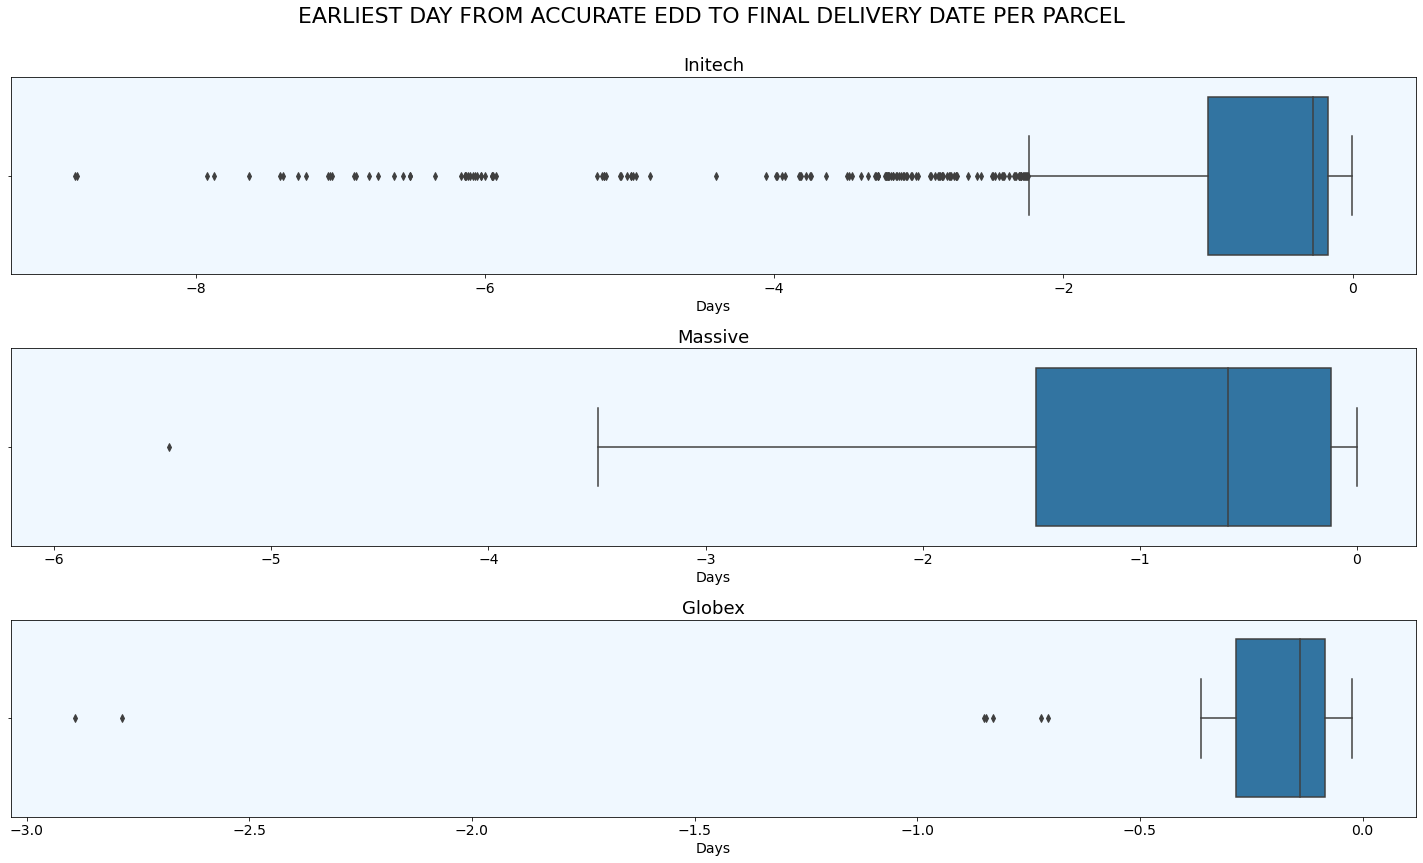

In [3293]:
plt.figure(figsize=(20,12))
plt.subplot(311)
plot_data = normal_edd_tbl2[normal_edd_tbl2['carrier_name']=='Initech'].groupby('parcel_id')['daydiff_log_FDD'].min()
sns.boxplot(plot_data)
plt.xlabel('Days')
plt.title('Initech', size=18)

plt.subplot(312)
plot_data = normal_edd_tbl2[normal_edd_tbl2['carrier_name']=='Massive'].groupby('parcel_id')['daydiff_log_FDD'].min()
sns.boxplot(plot_data)
plt.xlabel('Days')
plt.xlim(-6.2)
plt.title('Massive', size=18)

plt.subplot(313)
plot_data = normal_edd_tbl2[normal_edd_tbl2['carrier_name']=='Globex'].groupby('parcel_id')['daydiff_log_FDD'].min()
sns.boxplot(plot_data)
plt.xlabel('Days')
plt.title('Globex', size=18)

plt.suptitle('EARLIEST DAY FROM ACCURATE EDD TO FINAL DELIVERY DATE PER PARCEL', size=22, y=1)
plt.tight_layout()
plt.show()

#### 3. PARCELS WITH ACCURATE EDDs PER DELIVERY DURATION

Delivery duration = final_delivery_date - out_for_delivery_date

In [3294]:
# PREPARE DATA
last_normal_edd_tbl['delivery_duration_hours'] = (last_normal_edd_tbl['final_delivery_date'] - last_normal_edd_tbl['out_for_delivery_date']) / pd.Timedelta(1,'H')
# last_normal_edd_tbl['delivery_duration_days'] = (last_normal_edd_tbl['final_delivery_date'] - last_normal_edd_tbl['out_for_delivery_date']) / pd.Timedelta(1,'D')
def duration_hour_group(r):
    q1 = last_normal_edd_tbl['delivery_duration_hours'].quantile(.25)
    median = last_normal_edd_tbl['delivery_duration_hours'].median()
    q3 = last_normal_edd_tbl['delivery_duration_hours'].quantile(.75)

    if r <= q1:
        return f'0 - {q1:.2f} hrs'
    elif r <= median:
        return f'{q1:.2f} - {median:.2f} hrs'
    elif r <= q3:
        return f'{median:.2f} - {q3:.2f} hrs'
    else: 
        return f'> {q3:.2f} hrs'
last_normal_edd_tbl['dur_hour_group'] = last_normal_edd_tbl['delivery_duration_hours'].apply(duration_hour_group) 

dur_hour_tbl = last_normal_edd_tbl.groupby('dur_hour_group')\
        .apply(func_nunique)\

dur_hour_tbl.loc['All',:] = dur_hour_tbl.iloc[:,:].sum(axis=0, numeric_only=True)
dur_hour_tbl['perc_accurate_parcels %'] = dur_hour_tbl['parcels_with_accurate_EDDs'] / dur_hour_tbl['total_parcels'] * 100
dur_hour_tbl.reset_index(inplace=True)
dur_hour_tbl.iloc[:,1:4] = dur_hour_tbl.iloc[:,1:4].astype(int)
dur_hour_tbl

,dur_hour_group,total_parcels,parcels_with_accurate_EDDs,parcels_with_inaccurate_EDDs,perc_accurate_parcels %
0,0 - 2.27 hrs,802,216,586,26.93
1,2.27 - 4.19 hrs,801,306,495,38.20
2,4.19 - 7.49 hrs,801,315,486,39.33
3,> 7.49 hrs,801,373,428,46.57
4,All,3205,1210,1995,37.75


In [3295]:
# PLOT
plot_data = dur_hour_tbl.iloc[:-1].copy()
x = plot_data['dur_hour_group'].values

fig = go.Figure(data=[
    go.Bar(name='Total parcels', x=x, y=plot_data['total_parcels'], 
           marker_color='cornflowerblue',
           texttemplate='%{y:,} parcels<br>'
           ),
    go.Bar(name='Accurate parcels', x=x, y=plot_data['parcels_with_accurate_EDDs'], 
           marker_color='darkblue', 
           customdata= plot_data['perc_accurate_parcels %'], 
           texttemplate='%{y:,} parcels<br>(%{customdata:.2f} %)'
           )
])
fig.update_traces(textposition = 'outside')
fig.update_layout(
    barmode='group',
    width=1000,
    height=600,
    title='<b>NUMBER & PERCENTAGE OF ACCURATE PARCELS<br>PER DELIVERY DURATION GROUP<b>', title_font={'size':20},
    title_x=.45, title_y=.9,
    xaxis={'title': 'Delivery duration', 'showgrid':False}, 
    yaxis={'title':'Number of parcels', 'range': [0,875]}
)
fig.show()

LONGER DELIVERY DURATION HAS HIGHER EDD ACCURACY PER PARCEL AND VICE VERSA.

In [3350]:
print(f'''I DIVIDED TOTAL PARCELS INTO 4 GROUP OF DELIVERY DURATION, ALL OF WHICH CONTAINS 25% OF TOTAL PARCELS VOLUME ({dur_hour_tbl["total_parcels"].min()}-{dur_hour_tbl["total_parcels"].max()} PARCELS).

DELIVERY DURATION {dur_hour_tbl.iloc[-2,0]} HAS THE HIGHEST ACCURACY PERCENTAGE ({dur_hour_tbl.iloc[-2,-1]:.2f} %)

WHEREAS DURATION {dur_hour_tbl.iloc[0,0]} HAS THE LOWEST ACCURACY PERCENTAGE ({dur_hour_tbl.iloc[0,-1]:.2f} %).''')

I DIVIDED TOTAL PARCELS INTO 4 GROUP OF DELIVERY DURATION, ALL OF WHICH CONTAINS 25% OF TOTAL PARCELS VOLUME (801-3205 PARCELS).

DELIVERY DURATION > 7.49 hrs HAS THE HIGHEST ACCURACY PERCENTAGE (46.57 %)

WHEREAS DURATION 0 - 2.27 hrs HAS THE LOWEST ACCURACY PERCENTAGE (26.93 %).


#### 4. PARCELS WITH ACCURATE EDDs PER DELIVERY TIME

In [3297]:
# PLOT
x = ['0AM - 6AM (6hrs)', '6AM - 0AM (18 hrs)']
COUNT_TOTAL_MIDNIGHT = last_normal_edd_tbl[last_normal_edd_tbl['final_delivery_date'].dt.hour<6].shape[0]
COUNT_TOTAL_DAY = last_normal_edd_tbl[(last_normal_edd_tbl['final_delivery_date'].dt.hour>=6) & (last_normal_edd_tbl['final_delivery_date'].dt.hour<24)].shape[0]
COUNT_ACCURATE_MIDNIGHT = last_normal_edd_tbl[(last_normal_edd_tbl['EDD_is_accurate']==True) & (last_normal_edd_tbl['final_delivery_date'].dt.hour<6)].shape[0]
COUNT_ACCURATE_DAY = last_normal_edd_tbl[(last_normal_edd_tbl['EDD_is_accurate']==True) & 
                                       (last_normal_edd_tbl['final_delivery_date'].dt.hour>=6) 
                                       & (last_normal_edd_tbl['final_delivery_date'].dt.hour<24)].shape[0]
PERC_ACCURATE_MIDNIGHT = COUNT_ACCURATE_MIDNIGHT/COUNT_TOTAL_MIDNIGHT*100
PERC_ACCURATE_DAY = COUNT_ACCURATE_DAY/COUNT_TOTAL_DAY*100

y_total_parcels = [COUNT_TOTAL_MIDNIGHT, COUNT_TOTAL_DAY]
y_accurate_parcels = [COUNT_ACCURATE_MIDNIGHT, COUNT_ACCURATE_DAY]

fig = go.Figure(data=[
    go.Bar(name='Total parcels', x=x, y=y_total_parcels, 
           marker_color='cornflowerblue',
           customdata= [y_total_parcels[i]/TOTAL_PARCELS*100 for i in range(len(y_total_parcels))], 
           texttemplate='%{y:,} parcels<br>(%{customdata:.2f} %)', textposition = 'outside'
           ),
    go.Bar(name='Accurate parcels', x=x, y=y_accurate_parcels, 
           marker_color='darkblue', 
           customdata= [y_accurate_parcels[i]/y_total_parcels[i]*100 for i in range(len(y_total_parcels))], 
           texttemplate='%{y:,} parcels<br>(%{customdata:.2f} %)', textposition = 'outside'
           )
])
fig.update_layout(
    barmode='group',
    width=1000,
    height=600,
    title='<b>NUMBER & PERCENTAGE OF ACCURATE PARCELS<br>PER DELIVERY TIME<b>', title_font={'size':20},
    title_x=.45, title_y=.9,
    xaxis={'title': 'Delivery time of day', 'showgrid':False}, 
    yaxis={'title':'Number of parcels','range':[0,2800]}
)
fig.show()

In [3314]:
print(f'''
APPROXIMATELY 75% TOTAL PARCELS ({COUNT_TOTAL_MIDNIGHT:,} PARCELS) WERE DELIVERED DURING MIDNIGHT HOURS FROM 0AM TO 6AM,
    AND {PERC_ACCURATE_MIDNIGHT:.2F}% OF THEM ({COUNT_ACCURATE_MIDNIGHT:,} PARCELS) HAVE ACCURATE EDDS.
    
WHEREAS ONLY 25% TOTAL PARCELS ({COUNT_TOTAL_DAY:,} PARCELS) WERE DELIVERED DURING DAYTIME FROM 6AM TO 0AM,
    AND ONLY {PERC_ACCURATE_DAY:.2F}% OF THEM ({COUNT_ACCURATE_DAY:,} PARCELS) HAVE ACCURATE EDDS.
      ''')


APPROXIMATELY 75% TOTAL PARCELS (2,382 PARCELS) WERE DELIVERED DURING MIDNIGHT HOURS FROM 0AM TO 6AM,
    AND 41.39% OF THEM (986 PARCELS) HAVE ACCURATE EDDS.
    
WHEREAS ONLY 25% TOTAL PARCELS (823 PARCELS) WERE DELIVERED DURING DAYTIME FROM 6AM TO 0AM,
    AND ONLY 27.22% OF THEM (224 PARCELS) HAVE ACCURATE EDDS.
      


### **V. CHARACTERISTICS OF INACCURATE EDDs PARCELS**

Possible reasons/factors why a parcel EDD is predicted inaccurately:

- Parcels predicted to be delivered before date of prediction.

- Days between prediction and delivery date (FDD). 

    - Some parcels predicted very close to FDD but are still inaccurate

- Final delivery time of day

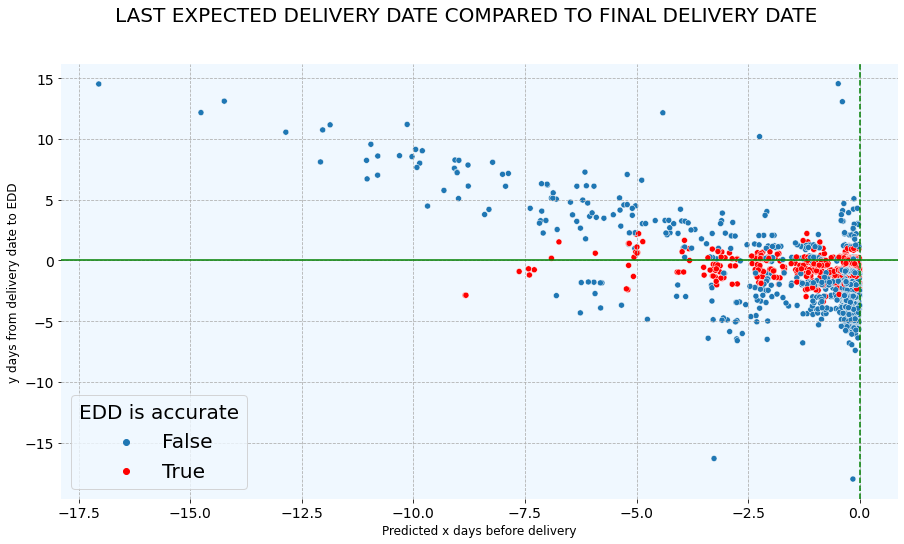

In [3299]:
# PLOT
plt.figure(figsize=(15,8))
ax = sns.scatterplot(x=last_normal_edd_tbl['daydiff_log_FDD'], 
                y=last_normal_edd_tbl['daydiff_bw_FDD_EDD'], 
                hue=last_normal_edd_tbl['EDD_is_accurate'], 
                palette=['C0', 'red']
)
plt.axhline(0, color='green', linestyle='-')
# plt.text(-17.5,-1.3, 'Perfect prediction')
plt.axvline(0, color='green', linestyle='dashed')
# plt.text(0.1, -15, 'Final delivery date', c='r')
# plt.axvline(-3.5, color='r', linestyle='dashed')
# plt.text(-6.05, -15, '3.5 days before FDD', color='r')

# AXIS LABEL
plt.xlabel('Predicted x days before delivery', size=12)
plt.ylabel('y days from delivery date to EDD', size=12)

plt.grid(axis='both', which='both', linestyle='--')
ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
plt.legend(title = 'EDD is accurate', fontsize='x-large', title_fontsize='20')
plt.suptitle('LAST EXPECTED DELIVERY DATE COMPARED TO FINAL DELIVERY DATE', size=20)
plt.show()

THIS GRAPH SHOWS WHEN THE LAST EDD PER EACH PARCEL IS MADE COMPARED TO FINAL_DELIVERY_DATE (FDD) AND THE TIME DIFFERENCE BETWEEN EDD AND FDD.

From this graph we can see that:

- There are lots of last EDDs made far from FDD.

- Many EDDs made very close to FDD but are still inaccurate.

#### 1. PARCELS PREDICTED TO BE DELIVERED BEFORE DATE OF PREDICTION

Days difference = EDD prediction date - EDD

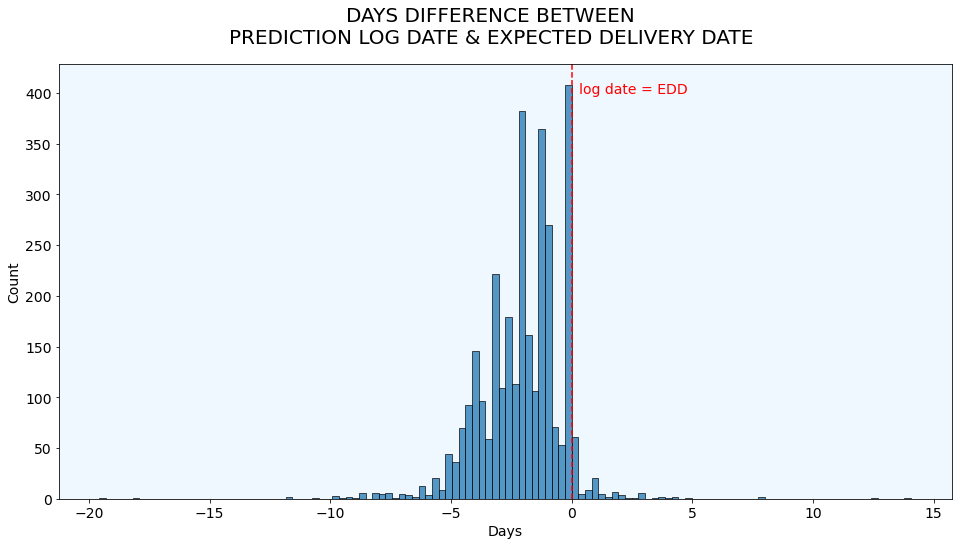

In [3346]:
plt.figure(figsize=(16,8))
sns.histplot(tmp['daydiff_log_EDD'])
plt.axvline(x=0, color='red', linestyle='--')
plt.text(0.3, 400, 'log date = EDD', c='red')
plt.suptitle('DAYS DIFFERENCE BETWEEN\nPREDICTION LOG DATE & EXPECTED DELIVERY DATE', size=20)
plt.xlabel('Days')
plt.show()

In [3351]:
tmp = last_normal_edd_tbl[(last_normal_edd_tbl['log_timestamp'].dt.date > last_normal_edd_tbl['new_parcel_expected_time_first_end'].dt.date) # LOG DATE AFTER EDD RANGE
              | ((last_normal_edd_tbl['new_parcel_expected_time_first_end'].isna()) & (last_normal_edd_tbl['log_timestamp'].dt.date > last_normal_edd_tbl['new_parcel_expected_time_first_start'].dt.date)) # LOG DATE IS AFTER EDD
              | ((last_normal_edd_tbl['new_parcel_expected_time_first_start'].isna()) & (last_normal_edd_tbl['log_timestamp'].dt.date > last_normal_edd_tbl['new_parcel_expected_time_first_end'].dt.date))]
COUNT_TMP = tmp["EDD_is_accurate"].shape[0]
PERC_TMP = tmp["EDD_is_accurate"].shape[0] / TOTAL_PARCELS * 100
print(f'{COUNT_TMP} PARCELS ({PERC_TMP:.2f}%) WERE PREDICTED TO BE DELIVERED BEFORE PREDICTION DATE, WHICH IS OBVIOUSLY INACCURATE.')

41 PARCELS (1.28%) WERE PREDICTED TO BE DELIVERED BEFORE PREDICTION DATE, WHICH IS OBVIOUSLY INACCURATE.


#### 2. DAYS BETWEEN PREDICTION AND DELIVERY DATE (FDD)

In [3301]:
# PREPARE DATA
def group_daydiff_log_FDD(r):
    '''
    Function to devide daydiff_log_FDD into 4 groups
    '''
    min = (last_normal_edd_tbl['daydiff_log_FDD'].min())
    q1 = last_normal_edd_tbl['daydiff_log_FDD'].quantile(.25)
    median = last_normal_edd_tbl['daydiff_log_FDD'].median()
    q3 = last_normal_edd_tbl['daydiff_log_FDD'].quantile(.75)

    if r<= q1:
        return f'{abs(q1):.2f} - {abs(min):.2f}'
    elif r <= median:
        return f'{abs(median):.2f} - {abs(q1):.2f}'
    elif r <= q3:
        return f'{abs(q3):.2f} - {abs(median):.2f}'
    else: 
        return f'0 - {abs(q3):.2f}'
    
last_normal_edd_tbl['predicted_days_before_FDD'] = last_normal_edd_tbl['daydiff_log_FDD'].apply(group_daydiff_log_FDD)

daydiff_log_FDD_tbl = last_normal_edd_tbl.groupby('predicted_days_before_FDD').apply(func_nunique)
daydiff_log_FDD_tbl.loc['All',:] = daydiff_log_FDD_tbl.iloc[:,:].sum(axis=0, numeric_only=True)
daydiff_log_FDD_tbl['perc_accurate_parcels %'] = daydiff_log_FDD_tbl['parcels_with_accurate_EDDs'] / daydiff_log_FDD_tbl['total_parcels'] * 100
daydiff_log_FDD_tbl['perc_inaccurate_parcels %'] = daydiff_log_FDD_tbl['parcels_with_inaccurate_EDDs'] / daydiff_log_FDD_tbl['total_parcels'] * 100
daydiff_log_FDD_tbl = daydiff_log_FDD_tbl.sort_values('predicted_days_before_FDD')
daydiff_log_FDD_tbl.reset_index(inplace=True)
daydiff_log_FDD_tbl.iloc[:,1:4] = daydiff_log_FDD_tbl.iloc[:,1:4].astype(int)
daydiff_log_FDD_tbl

,predicted_days_before_FDD,total_parcels,parcels_with_accurate_EDDs,parcels_with_inaccurate_EDDs,perc_accurate_parcels %,perc_inaccurate_parcels %
0,0 - 0.13,801,228,573,28.46,71.54
1,0.13 - 0.21,801,300,501,37.45,62.55
2,0.21 - 0.35,801,333,468,41.57,58.43
3,0.35 - 17.05,802,349,453,43.52,56.48
4,All,3205,1210,1995,37.75,62.25


EDD PREDICTED CLOSER TO FINAL DELIVERY DATE (FDD) HAS HIGHER EDD INACCURACY PER PARCEL AND VICE VERSA.



In [3303]:
print(f'''I divided total parcels into 4 group of days difference between log date & FDD, 
      
    all of which contains 25% of total parcels volume ({plot_data["total_parcels"].min()}-{plot_data["total_parcels"].max()} parcels).

Parcels predicted {plot_data.iloc[0,0]} days before FDD has the highest inaccuracy percentage ({plot_data.iloc[0,-1]:.2f} %)

Whereas parcels predicted {plot_data.iloc[-1,0]} days before FDD has the lowest inaccuracy percentage ({plot_data.iloc[-1,-1]:.2f} %).''')

I divided total parcels into 4 group of days difference between log date & FDD, 
      
    all of which contains 25% of total parcels volume (801-802 parcels).

Parcels predicted 0 - 0.13 days before FDD has the highest inaccuracy percentage (71.54 %)

Whereas parcels predicted 0.35 - 17.05 days before FDD has the lowest inaccuracy percentage (56.48 %).


In [3302]:
# PLOT
plot_data = daydiff_log_FDD_tbl.iloc[:-1].copy()
x = plot_data['predicted_days_before_FDD'].values

fig = go.Figure(data=[
    go.Bar(name='Total parcels', 
            x=x, y=plot_data['total_parcels'], 
           marker_color='cornflowerblue',
           texttemplate='%{y:,} parcels<br>'
           ),
    go.Bar(name='Inaccurate parcels', 
            x=x, y=plot_data['parcels_with_inaccurate_EDDs'], 
           marker_color='darkblue', 
           customdata= plot_data['perc_inaccurate_parcels %'], 
           texttemplate='%{y:,} parcels<br>(%{customdata:.2f} %)'
           )
])
fig.update_traces(textposition = 'outside')
fig.update_layout(
    barmode='group',
    width=1000,
    height=600,
    title='<b>NUMBER & PERCENTAGE OF INACCURATE PARCELS<br>PER <b>', title_font={'size':20},
    title_x=.45, title_y=.9,
    xaxis={'title': 'x days predicted before FDD', 'showgrid':False}, 
    yaxis={'title':'Number of parcels', 'range': [0,875]}
)
fig.show()

**WHY PARCELS HAVING EDD PREDICTED 3 HOURS BEFORE DELIVERY DATE ARE STILL INACCURATE?**

In [3304]:
# PREPARE DATA
def group_daydiff_FDD_EDD(r):
    '''
    Function to devide daydiff_bw_FDD_EDD into 4 groups
    '''
    min = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].min()
    q1 = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].quantile(.25)
    median = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].median()
    q3 = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].quantile(.75)
    max = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].max()

    if r <= q1:
        return f'{min:.2f} to {q1:.2f}'
    elif r <= median:
        return f'{q1:.2f} to {median:.2f}'
    elif r <= q3:
        return f'{median:.2f} to {q3:.2f}'
    else: 
        return f'{q3:.2f} to {max:.2f}'
    
last_normal_edd_tbl['days_from_FDD_to_EDD'] = last_normal_edd_tbl['daydiff_bw_FDD_EDD'].apply(group_daydiff_FDD_EDD)

# WHY PARCELS PREDICTED 3 HOURS BEFORE FDD STILL INACCURATE?
tmp_tbl = last_normal_edd_tbl[(last_normal_edd_tbl['predicted_days_before_FDD']=='0 - 0.13') & (last_normal_edd_tbl['EDD_is_accurate']==False)] 
daydiff_FDD_EDD_tbl_2 = tmp_tbl.groupby('days_from_FDD_to_EDD')['parcel_id'].nunique().reset_index(name='total_inaccurate_parcels').set_index('days_from_FDD_to_EDD')
daydiff_FDD_EDD_tbl_2.loc['All parcels predicted 3 hrs before FDD',:] = daydiff_FDD_EDD_tbl_2.iloc[:,:].sum(axis=0, numeric_only=True)
daydiff_FDD_EDD_tbl_2['percentage %'] = daydiff_FDD_EDD_tbl_2['total_inaccurate_parcels'] / daydiff_FDD_EDD_tbl_2.iloc[-1,0] * 100
order_map = {'-17.99 to -2.49':1,
         '-2.49 to -1.37':2,
         '-1.37 to -0.20':3,
        '-0.20 to 14.55':4,
        'All':5}
daydiff_FDD_EDD_tbl_2 = daydiff_FDD_EDD_tbl_2.sort_values(by='days_from_FDD_to_EDD', key=lambda x: x.map(order_map))
daydiff_FDD_EDD_tbl_2.reset_index(inplace=True)
daydiff_FDD_EDD_tbl_2['total_inaccurate_parcels'] = daydiff_FDD_EDD_tbl_2['total_inaccurate_parcels'].astype(int)
daydiff_FDD_EDD_tbl_2

,days_from_FDD_to_EDD,total_inaccurate_parcels,percentage %
0,-17.99 to -2.49,228,39.79
1,-2.49 to -1.37,192,33.51
2,-1.37 to -0.20,85,14.83
3,-0.20 to 14.55,68,11.87
4,All parcels predicted 3 hrs before FDD,573,100.00


According to previous analysis, 71.54% (573 parcels) having last EDD predicted about 3 hours before final delivery date (FDD) are inaccurate.

Among them, 39.79% (228 parcels) were predicted to be delivered at least 2.5 after final delivery date.

#### 3. FINAL DELIVERY TIME OF DAY

In [3305]:
# PREPARE DATA
last_normal_edd_tbl['FDD_hour'] = last_normal_edd_tbl['final_delivery_date'].dt.hour + last_normal_edd_tbl['final_delivery_date'].dt.minute / 60
# last_normal_edd_tbl['FDD_hour'].describe()

def fdd_hour_group(r):
    '''
    Function to devide final_delivery_date into 4 groups:
    0-6 AM (midnight), 6-12PM (morning), 12-18PM (afternoon), 18-0AM (night)
    '''
    q1 = last_normal_edd_tbl['FDD_hour'].quantile(.25)
    median = last_normal_edd_tbl['FDD_hour'].median()
    q3 = last_normal_edd_tbl['FDD_hour'].quantile(.75)

    if r<= q1:
        return f'0-{q1:.2f}'
    elif r <= median:
        return f'{q1:.2f}-{median:.2f}'
    elif r <= q3:
        return f'{median:.2f}-{q3:.2f}'
    else: 
        return f'{q3:.2f}-0'

last_normal_edd_tbl['FDD_hour_of_day_group'] = last_normal_edd_tbl['FDD_hour'].apply(fdd_hour_group)
# DROP UNESCESSARY COLUMN
last_normal_edd_tbl.drop('FDD_hour', axis=1, inplace=True)

fdd_hour_tbl = last_normal_edd_tbl.groupby('FDD_hour_of_day_group').apply(func_nunique)
fdd_hour_tbl.loc['All',:] = fdd_hour_tbl.iloc[:,:].sum(axis=0, numeric_only=True)
fdd_hour_tbl['perc_accurate_parcels %'] = fdd_hour_tbl['parcels_with_accurate_EDDs'] / fdd_hour_tbl['total_parcels'] * 100
fdd_hour_tbl['perc_inaccurate_parcels %'] = fdd_hour_tbl['parcels_with_inaccurate_EDDs'] / fdd_hour_tbl['total_parcels'] * 100
fdd_hour_tbl['FDD_hour_group_start'] = [float(fdd_hour_tbl.iloc[:-1].index[i].split('-')[0]) for i in range(len(fdd_hour_tbl)-1)].append('All')
fdd_hour_tbl = fdd_hour_tbl.sort_values('FDD_hour_group_start').drop('FDD_hour_group_start', axis=1)
fdd_hour_tbl.reset_index(inplace=True)
fdd_hour_tbl.iloc[:,1:4] = fdd_hour_tbl.iloc[:,1:4].astype(int)
fdd_hour_tbl

,FDD_hour_of_day_group,total_parcels,parcels_with_accurate_EDDs,parcels_with_inaccurate_EDDs,perc_accurate_parcels %,perc_inaccurate_parcels %
0,0-1.72,805,296,509,36.77,63.23
1,1.72-3.42,801,359,442,44.82,55.18
2,3.42-6.08,800,339,461,42.38,57.63
3,6.08-0,799,216,583,27.03,72.97
4,All,3205,1210,1995,37.75,62.25


In [3306]:
print(f'''I divided total parcels into 4 group of delivery time, all of which contains 25% of total parcels volume ({fdd_hour_tbl["total_parcels"].min():,}-{fdd_hour_tbl["total_parcels"].max():,} parcels).

Delivery time {fdd_hour_tbl.iloc[-2,0]} of day (from morning till before midnight) has the highest inaccuracy percentage ({fdd_hour_tbl.iloc[-2,-1]:.2f} %)

Whereas delivery time {fdd_hour_tbl.iloc[1,0]} of day has the lowest inaccuracy percentage ({fdd_hour_tbl.iloc[1,-1]:.2f} %).''')

I divided total parcels into 4 group of delivery time, all of which contains 25% of total parcels volume (799-3,205 parcels).

Delivery time 6.08-0 of day (from morning till before midnight) has the highest inaccuracy percentage (72.97 %)

Whereas delivery time 1.72-3.42 of day has the lowest inaccuracy percentage (55.18 %).


## E. CONCLUSION

**1. CARRIERS' VOLUME AND EDD ACCURACY**

- 37.75% of total volume (1,210 parcels) have accurate EDDs.

- Globex has the lowest parcels volume (45 parcels), but highest percentage of accurate EDD parcels (93.33%).

- Initech has the highest parcels volume (3,069 parcels), but low percentage of accurate EDD parcels (37.15%).

**2. SUCCESSFUL DELIVERY RATE**

- 86.05% (2,758) of total parcels were delivered on first attempt.

- All 3 carriers has > 85% successful delivery percentage on first attempt.

**3. CHARACTERISTICS OF ACCURATE EDDs PARCELS**

i. EDDs Frequency

- Among 80.67% (2,576) parcels having only 1 unique EDD, there are 994 (31.01%) parcels have accurate EDDs.

- Only 19.63% (629) parcels have more than 1 unique EDD, and 6.74% (216) of which have accurate EDDs.

ii. Earliest day that all EDDs per parcel were predicted accurately is 8.84 days before the final delivery date.

iii. Longer delivery duration has higher EDD accuracy per parcel.

iv. Final delivery time of day

- 75% total parcels (2,382 parcels) were delivered during midnight hours from 0am to 6am, and 41.39% of them (986 parcels) have accurate EDDs.

- Only 25% total parcels (823 parcels) were delivered during daytime from 6am to 0am, and only 27.22% of them (224 parcels) have accurate EDDs

**4. CHARACTERISTICS OF INACCURATE EDDs PARCELS**

- EDD predicted closer to final delivery date has higher edd inaccuracy per parcel and vice versa.

- Delivery time of day from 6am to 0am has highest inaccuratcy edd percentage.

- 1.28% parcels were predicted to be delivered before prediction date, which is obviously inaccurate.